# Examining zed and force plate signals

The two devices started recording at different time and have different frequencies (fp at 100 Hz, zed at ~25 Hz).  
We are able to detect the start of the stepping forward in the zed data and the first foot touch in the force plate data,  
They are not the exact same event but relativly close.

In [1]:
import sys
import os

project_root = os.path.abspath(os.path.join(os.getcwd(), "..", ".."))
if project_root not in sys.path:
    sys.path.insert(0, project_root)

In [2]:
import pandas as pd
import numpy as np
import seaborn as sns
import matplotlib.pyplot as plt
from astropy.timeseries import LombScargle
from scipy.interpolate import interp1d
from src.preprocessing import load_and_process_zed_data, load_and_process_force_plate_data, trim_dataframe_with_window

In [5]:
force_plate_file_path = "../../data/raw/older_adults/ann/ann_force_plate/ann_eyes_closed2.txt"
df_fp = load_and_process_force_plate_data(force_plate_file_path)

zed_file_path = "../../data/raw/older_adults/ann/ann_zed/ann_eyes_closed2.csv"
_, df_com = load_and_process_zed_data(zed_file_path)

In [6]:
df_fp_trimmed = trim_dataframe_with_window(df_fp, 'time (s)', 'Fz', frames_num=50)
df_com_trimmed = trim_dataframe_with_window(df_com, 'time (s)', 'COM_AP', frames_num=100)

### Frequency of the Zed camera is not constant 

<Axes: ylabel='time (s)'>

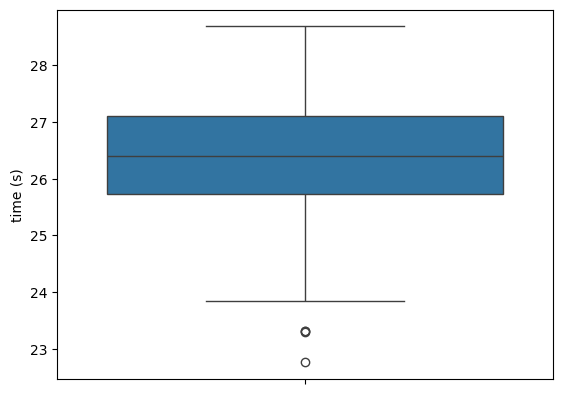

In [7]:
time = df_com_trimmed['time (s)']
delta_t = time.diff().dropna()

sns.boxplot(1/delta_t)

In [8]:
# Align all time axes to start at 0
time_fp = df_fp_trimmed["time (s)"] - df_fp_trimmed["time (s)"].iloc[0]
time_zed = df_com_trimmed["time (s)"] - df_com_trimmed["time (s)"].iloc[0]

# -------------------- ML Direction --------------------
com_ml_centered = df_com_trimmed["COM_ML"] - df_com_trimmed["COM_ML"].mean()
cop_ml_centered = df_fp_trimmed["Ax"] - df_fp_trimmed["Ax"].mean()

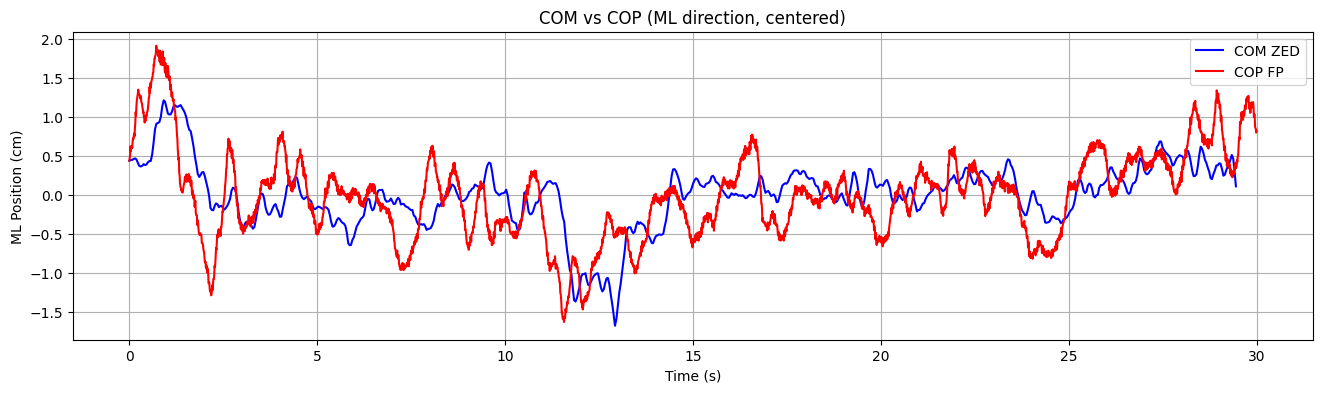

In [9]:
plt.figure(figsize=(16, 4))
plt.plot(time_zed, com_ml_centered, label="COM ZED", color='blue')
plt.plot(time_fp, cop_ml_centered, label="COP FP", color='red')

plt.xlabel("Time (s)")
plt.ylabel("ML Position (cm)")
plt.title("COM vs COP (ML direction, centered)")
plt.legend()
plt.grid(True)
plt.show()


### NFFT

In [10]:
# Compute Lomb-Scargle for COM (non-uniform time)
ls_com = LombScargle(time_zed, com_ml_centered)
freq_com, power_com = ls_com.autopower()

# Compute FFT for COP (uniform time, use regular FFT)
fs_fp = 100  # Hz
n = len(cop_ml_centered)
freq_fp = np.fft.rfftfreq(n, d=1/fs_fp)
fft_cop = np.fft.rfft(cop_ml_centered)
power_cop = np.abs(fft_cop)**2

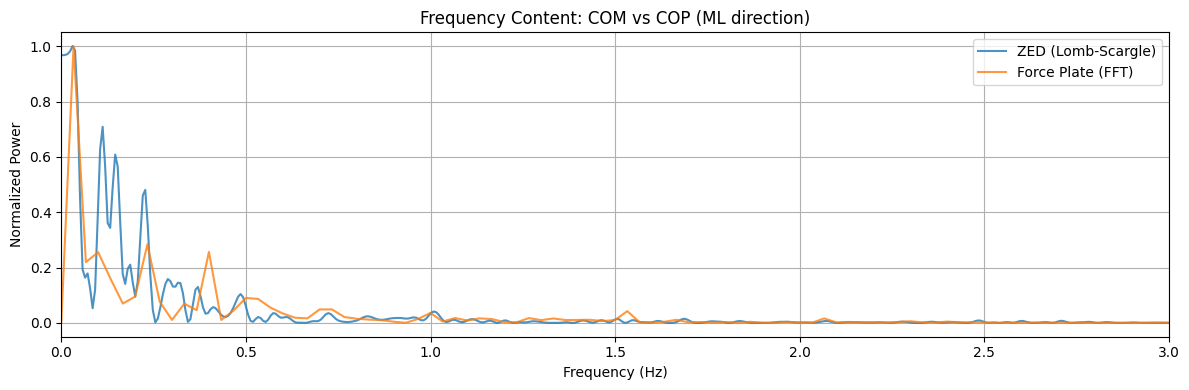

In [11]:
# Plot both spectra
plt.figure(figsize=(12, 4))
plt.plot(freq_com, power_com / max(power_com), label="ZED (Lomb-Scargle)", alpha=0.8)
plt.plot(freq_fp, power_cop / max(power_cop), label="Force Plate (FFT)", alpha=0.8)
plt.xlabel("Frequency (Hz)")
plt.xlim(0, 3)  # Only show sway-relevant frequencies
plt.ylabel("Normalized Power")
plt.title("Frequency Content: COM vs COP (ML direction)")
plt.legend()
plt.grid(True)
plt.tight_layout()
plt.show()

In [12]:
# -------------------- Custom Frequency Grid --------------------

# Define frequency grid from 0.01 to 3 Hz with high resolution
NFFT = 4096
f_min, f_max = 0.01, 3.0
frequency_grid = np.linspace(f_min, f_max, NFFT)

# -------------------- ZED (Lomb-Scargle) --------------------

ls_com = LombScargle(time_zed, com_ml_centered)
power_com = ls_com.power(frequency_grid)

# -------------------- Force Plate (FFT) --------------------

fs_fp = 100  # Sampling rate
n = len(cop_ml_centered)
freq_fp = np.fft.rfftfreq(n, d=1/fs_fp)
fft_cop = np.fft.rfft(cop_ml_centered)
power_cop = np.abs(fft_cop)**2

# Interpolate FFT to match Lomb-Scargle frequency grid
interp_fp = interp1d(freq_fp, power_cop, bounds_error=False, fill_value=0)
power_cop_interp = interp_fp(frequency_grid)

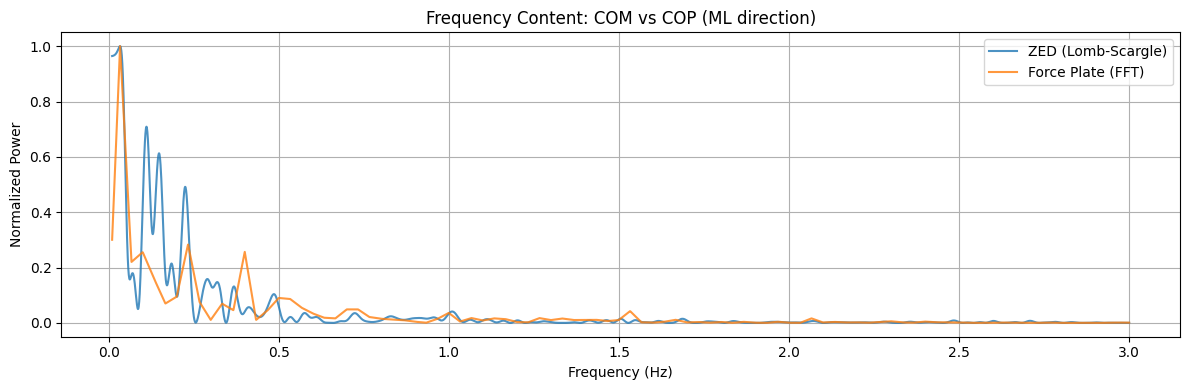

In [13]:
plt.figure(figsize=(12, 4))
plt.plot(frequency_grid, power_com / max(power_com), label="ZED (Lomb-Scargle)", alpha=0.8)
plt.plot(frequency_grid, power_cop_interp / max(power_cop_interp), label="Force Plate (FFT)", alpha=0.8)
plt.xlabel("Frequency (Hz)")
plt.ylabel("Normalized Power")
plt.title("Frequency Content: COM vs COP (ML direction)")
plt.legend()
plt.grid(True)
plt.tight_layout()
plt.show()

In [14]:
peak_freq_com = frequency_grid[np.argmax(power_com)]
peak_freq_fp = frequency_grid[np.argmax(power_cop_interp)]

print(f"ZED dominant frequency: {peak_freq_com:.3f} Hz")
print(f"Force Plate dominant frequency: {peak_freq_fp:.3f} Hz")


ZED dominant frequency: 0.033 Hz
Force Plate dominant frequency: 0.033 Hz


In [15]:
target_freq = peak_freq_fp

idx_fp = np.argmin(np.abs(freq_fp - target_freq))
phase_fp = np.angle(fft_cop[idx_fp])

# Build sine and cosine basis functions at target_freq
sin_term = np.sin(2 * np.pi * target_freq * time_zed)
cos_term = np.cos(2 * np.pi * target_freq * time_zed)

# Design matrix
X = np.column_stack((sin_term, cos_term))

# Least squares fit to com_ml_centered
coeffs, _, _, _ = np.linalg.lstsq(X, com_ml_centered, rcond=None)
a, b = coeffs

# Phase of ZED signal at target frequency
phase_zed = np.arctan2(b, a)


# Phase difference
delta_phase = phase_zed - phase_fp
delta_phase = np.angle(np.exp(1j * delta_phase))  # wrap to [-π, π]

# Convert to time lag
delta_time = delta_phase / (2 * np.pi * target_freq)

print(f"Phase difference: {np.degrees(delta_phase):.2f}°")
print(f"Time lag: {delta_time:.3f} seconds")

Phase difference: 103.74°
Time lag: 8.637 seconds


If delta_time > 0 → ZED is lagging behind force plate  
If delta_time < 0 → ZED is leading the force plate  

Since the Zed detected event (start of movement) occurs before the force plate detected event (foot touch), we expect the Zed to lag behind (positive `delta_time`)

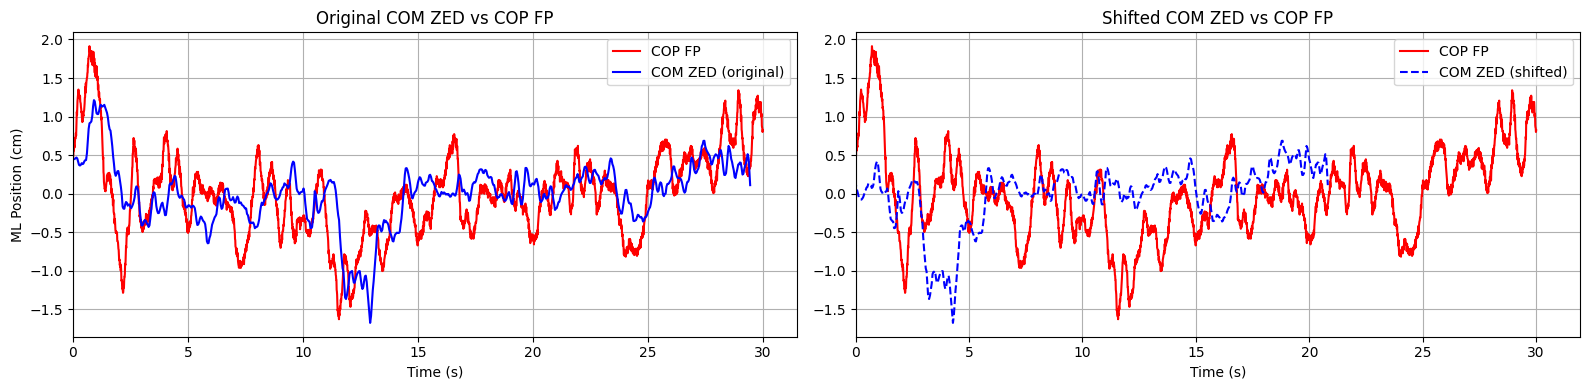

In [16]:
plt.figure(figsize=(16, 4))

# -------- Subplot 1: Original COM ZED vs COP FP --------
plt.subplot(1, 2, 1)
plt.plot(time_fp, cop_ml_centered, label="COP FP", color='red')
plt.plot(time_zed, com_ml_centered, label="COM ZED (original)", color='blue')
plt.xlabel("Time (s)")
plt.ylabel("ML Position (cm)")
plt.title("Original COM ZED vs COP FP")
plt.legend()
plt.grid(True)
plt.xlim(0)

# -------- Subplot 2: Shifted COM ZED vs COP FP --------
plt.subplot(1, 2, 2)
plt.plot(time_fp, cop_ml_centered, label="COP FP", color='red')
plt.plot(time_zed - delta_time, com_ml_centered, label="COM ZED (shifted)", color='blue', linestyle='--')
plt.xlabel("Time (s)")
plt.title("Shifted COM ZED vs COP FP")
plt.legend()
plt.grid(True)
plt.xlim(0)

plt.tight_layout()
plt.show()
